In [ ]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
import albumentations as A
import albumentations.augmentations.functional as aF
from albumentations.pytorch import ToTensor
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensor
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

import random

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Скачаем датасет

[The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

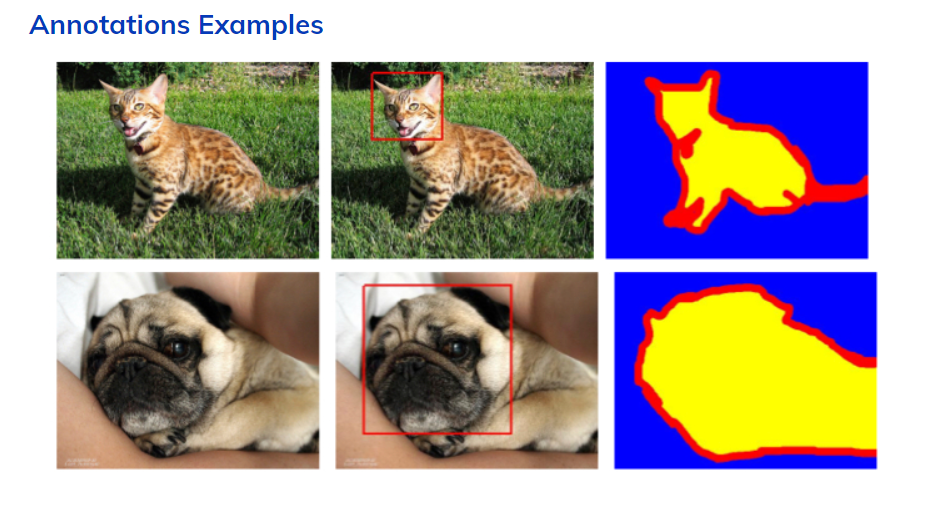

In [ ]:
!mkdir dataset

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  33.7M      0  0:00:22  0:00:22 --:--:-- 35.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  13.1M      0  0:00:01  0:00:01 --:--:-- 13.1M


In [ ]:
!tar -xf images.tar.gz -C dataset/
!tar -xf annotations.tar.gz -C dataset/

# Разделим скаченные данные на подвыборки


Некоторые файлы в наборе данных повреждены, поэтому мы будем использовать только те файлы изображений, которые OpenCV может правильно загрузить. Мы будем использовать 1000 изображений для обучения, 300 изображения для проверки и 100 изображений для тестирования.

In [ ]:
dataset_directory = 'dataset'
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:1000]
val_images_filenames = correct_images_filenames[1000:1300]
test_images_filenames = images_filenames[1300:1400]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1000 300 100


# Определим функцию препроцессинга маски

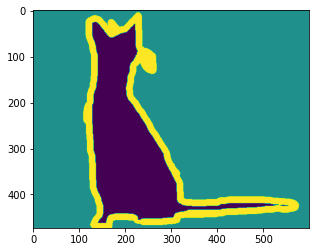

In [ ]:
test_mask = cv2.imread('/content/dataset/annotations/trimaps/Abyssinian_2.png', cv2.IMREAD_UNCHANGED)
plt.imshow(test_mask)

In [ ]:
np.unique(test_mask)

array([1, 2, 3], dtype=uint8)

Набор данных содержит сегментацию обрезки на уровне пикселей. Для каждого изображения есть связанный файл PNG с маской. Размер маски равен размеру связанного изображения. Каждый пиксель изображения маски может принимать одно из трех значений: 1, 2 или 3. 1 означает, что этот пиксель изображения принадлежит классу pet, 2 - фону класса, 3 - границе класса. Поскольку этот пример демонстрирует задачу двоичной сегментации (то есть присвоение одного из двух классов каждому пикселю), мы предварительно обработаем маску, поэтому она будет содержать только два уникальных значения: 0,0, если пиксель является фоном, и 1,0, если пиксель является домашним животным или границей.

In [ ]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask==2.0] = 0.0
    mask[(mask==1.0)| (mask==3.0)] = 1.0
    return mask

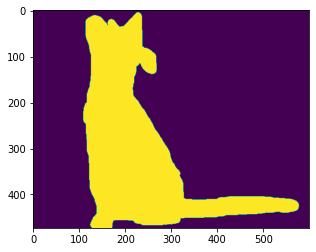

In [ ]:
test_mask = preprocess_mask(test_mask)
plt.imshow(test_mask)

# Визуализация датасета

In [ ]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 7
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()

        if i == 6:
          return
    plt.tight_layout()
    plt.show()

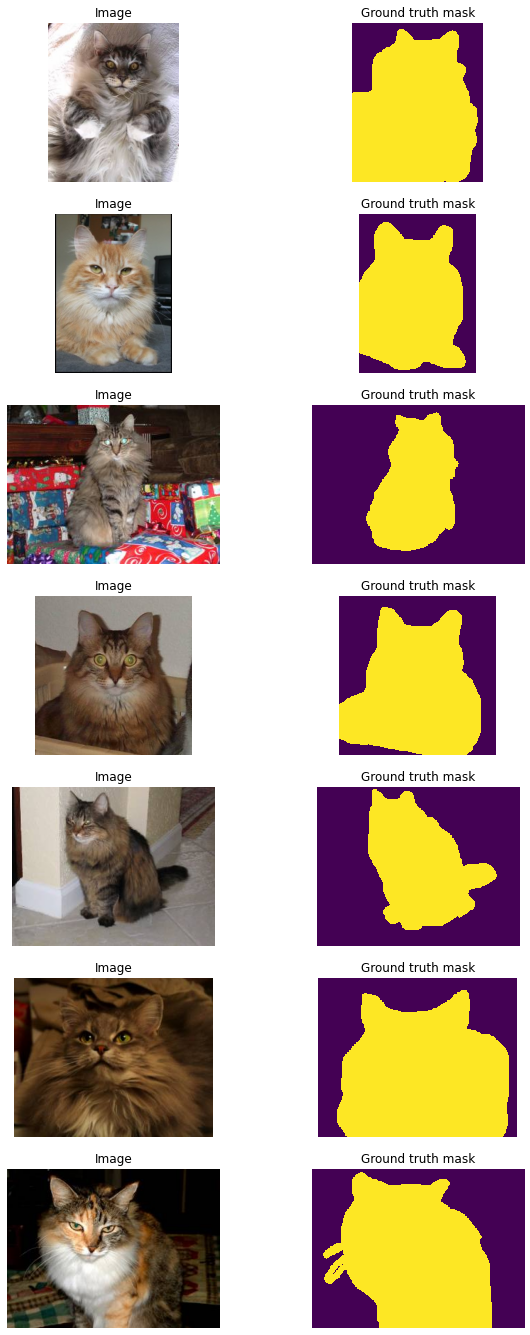

In [ ]:
display_image_grid(test_images_filenames, images_directory, masks_directory)

# Пишем класс датасета

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory:str = images_directory
        self.masks_directory:str = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image_path = os.path.join(self.images_directory, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_filename = self.images_filenames[idx].replace('.jpg', '.png')
        mask_path = os.path.join(self.masks_directory, mask_filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        mask = preprocess_mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask


Создаем пайплайны аугументаций для наборов данных для обучения и валидации. Обратите внимание, что мы используем A.Resize (256, 256) для изменения размера входных изображений и масок до размера 256x256 пикселей.

In [ ]:
from albumentations.augmentations.transforms import RandomBrightnessContrast
train_transform = A.Compose(
    [
     A.Resize(256, 256), 
     A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.35, p=0.5),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=60, p=0.7),
     ToTensor()
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensor()]
)
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

Давайте определим функцию, которая принимает набор данных и визуализирует различные аугументации, применяемые к одному и тому же изображению и связанной маске.

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensor))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

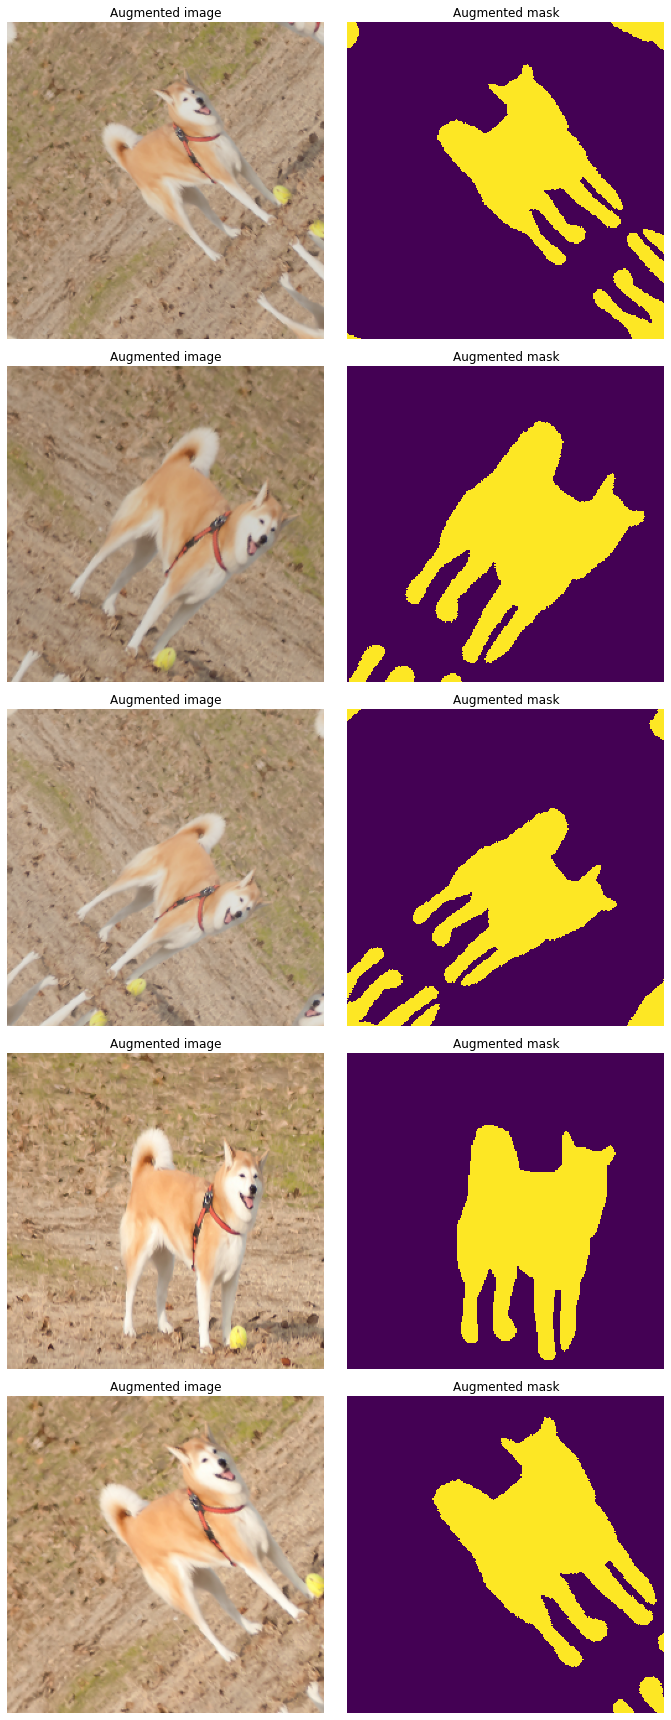

In [ ]:
random.seed(42)
visualize_augmentations(train_dataset, idx=55)

#  Напишем модель u-net

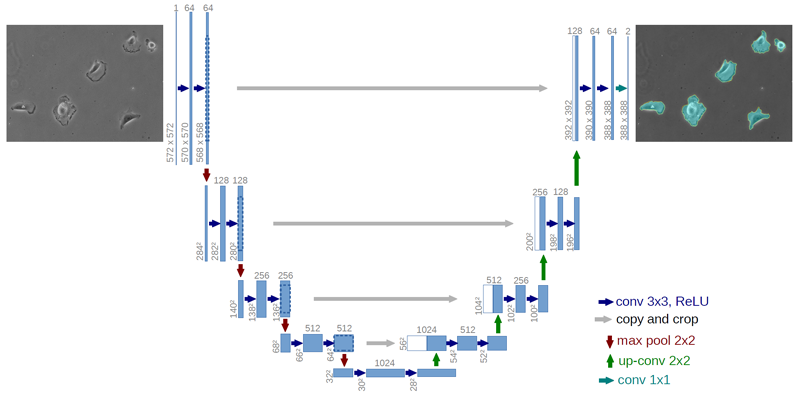

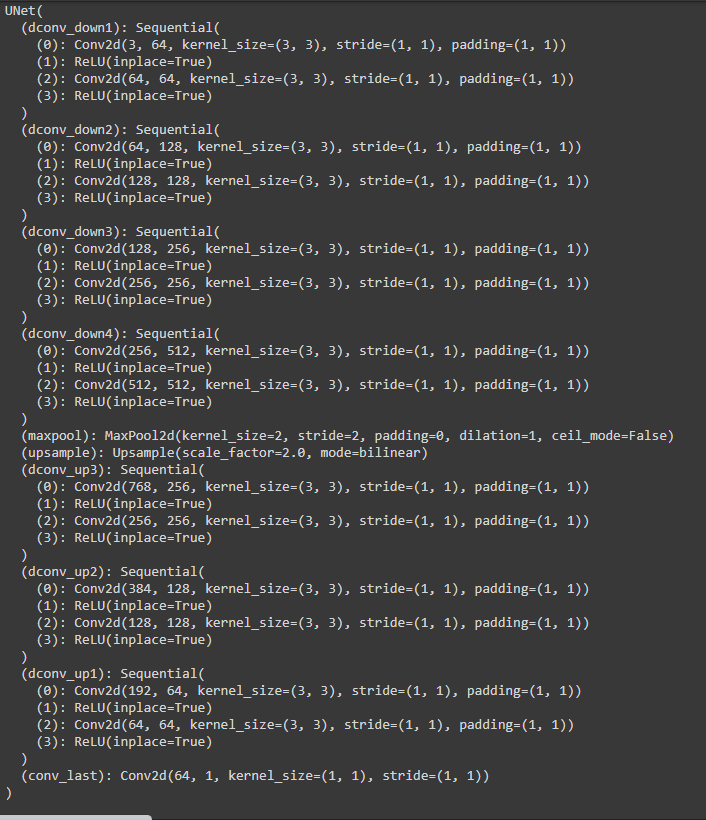

In [ ]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
   return nn.Sequential(
       nn.Conv2d(in_channels, out_channels, 3, padding=1),
       nn.ReLU(inplace=True),
       nn.Conv2d(out_channels, out_channels, 3, padding=1),
       nn.ReLU(inplace=True)
   )
   
#напишите функцию init и forward
class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.max_pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2.0, mode='bilinear', 
                                    align_corners=True)
        
        self.dconv_up1 = double_conv(512 + 256, 256)
        self.dconv_up2 = double_conv(256 + 128, 128)
        self.dconv_up3 = double_conv(128 + 64, 64)
        self.last_conv = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.max_pool(conv1)
        
        conv2 = self.dconv_down2(x)
        x = self.max_pool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.max_pool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up1(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up3(x)

        x = self.last_conv(x)

        return x        

In [ ]:
model = UNet(1)
model.to(device)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (max_pool): MaxPool2d(kern

## Определим функцию мониторинга качества

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

## Определим функцию потерь

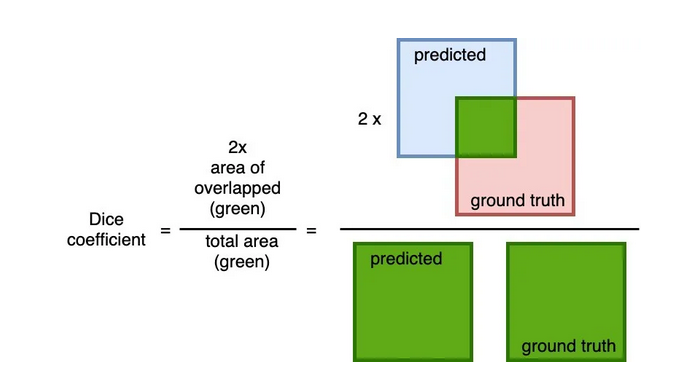

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    inter = (pred*target).sum(dim=2).sum(dim=2)

    loss = (1-((2.0*inter+smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))) 
    return loss.mean()

In [ ]:
def calc_loss(pred, target, bce_weight=0.5):
   
    '''совместите фукцию потерь dice и BCE по формуле 
    loss = bce * bce_weight + dice * (1 - bce_weight)
    '''
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss.to(device)

## Напишем функции трейна, валидации и предикта

In [ ]:
def train(train_loader, model, optimizer, epoch):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        '''ваш код здесь
        '''
        images = images.to(device)
        target = target.to(device)
        output = model(images)
        loss = calc_loss(output, target)
        metric_monitor.update("Loss", loss.item())
    
        '''
        ваш код здесь
        '''
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [ ]:
def validate(val_loader, model, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(device) 
            target = target.to(device)
            output = model(images)
            loss = calc_loss(output, target)

            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [ ]:
def predict(model, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(device, non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

In [ ]:
'''напишите параметры для обучения сети '''
device = torch.device('cuda')
epochs = 10
lr = 0.01
batch_size= 7
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)                          

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def train_and_validate(model, train_dataset, val_dataset):
    '''напишите train_loader и val_loader'''
    for epoch in range(1, epochs + 1):
        train(train_loader, model, optimizer, epoch)
        validate(val_loader, model, epoch)
    return model

In [ ]:
model = train_and_validate(model, train_dataset, val_dataset)

  0%|          | 0/143 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch: 10. Validation. Loss: 0.330: 100%|██████████| 43/43 [00:06<00:00,  7.14it/s]


## Предиктим результаты тестовой выборки

In [ ]:
class OxfordPetInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        '''ваш код здесь'''
        image_filename = self.images_filenames[idx]
        image_path = os.path.join(self.images_directory, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform:
          transformed = self.transform(image=image)
          image = transformed['image']
          
        return image, original_size

In [ ]:
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensor()]
)
test_dataset = OxfordPetInferenceDataset(test_images_filenames, images_directory, transform=test_transform,)

In [ ]:
predictions = predict(model, test_dataset, batch_size=16)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Визуализируем результаты

In [ ]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = aF.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)

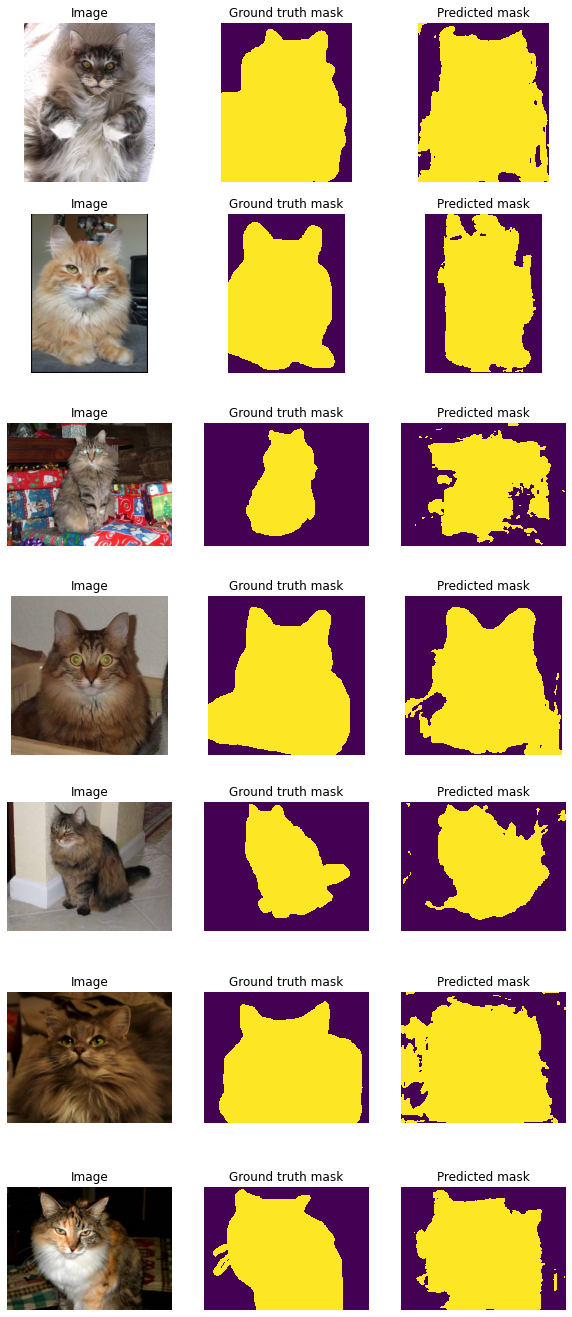

In [ ]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)